In [31]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler


# Modelando os dados

In [2]:
df = pd.read_excel('CONSUMO MENSAL DE ENERGIA ELÉTRICA POR CLASSE.xls', sheet_name = 'CONSUMO INDUSTRIAL POR UF', header = 4, index_col = 0)
df.head(5)

,2004,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 240
NaN,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,...,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ
TOTAL POR UF,12008851.66,12141416.57,12608412.95,12887290.731,12832711.92,13107635.62,13306806.95,13592340.78,13460814.76,13534732.69,...,15970242.42,15786702.72,15751225.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rondônia,17012,15490,18641,16961,17462,18505,18387,19468,20556,19642,...,43035.41,42100.7,43743.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Acre,1738.44,1724.13,1880.84,1714.65,1704.45,1961.75,1809.39,2103.44,2542.48,2220.39,...,3574.5,3518.33,4031.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amazonas,93449,101555.76,101814,102970.41,104589,107710,112740,113924.95,113649.57,126345.82,...,175915,160840,176895,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df2 = df.loc[['São Paulo']].values.astype('float')
df2[0,:-12]

array([3499333.91, 3641580.49, 3677373.42, 3913242.19, 3753889.16,
       3936932.41, 3953979.88, 4052294.36, 4120856.27, 4128933.33,
       4092032.16, 4054099.24, 3691575.32, 3792977.51, 3860019.49,
       4013268.84, 3927007.68, 4011756.85, 4076122.85, 4133091.64,
       4164235.93, 4155937.68, 4090785.98, 4036283.16, 3856964.24,
       4055481.62, 4198222.16, 4194942.2 , 4052097.98, 4151300.84,
       4165531.97, 4273783.44, 4224977.28, 4280542.4 , 4300324.22,
       4275335.72, 4049589.  , 4188532.  , 4329715.  , 4507532.  ,
       4439199.  , 4544459.  , 4426115.  , 4488819.  , 4661174.  ,
       4590297.  , 4690139.  , 4536199.  , 4221172.  , 4467742.  ,
       4408751.  , 4470594.  , 4525926.  , 4471787.  , 4615994.  ,
       4763449.  , 4632118.  , 4701595.  , 4594345.  , 4159358.  ,
       3662816.  , 3928530.  , 4087697.  , 4168105.  , 4108187.  ,
       4137079.  , 4252347.  , 4386733.  , 4463013.  , 4574343.  ,
       4565298.  , 4276521.  , 3864342.  , 4371815.  , 4485528

In [4]:
index = pd.date_range('2004 Jan', periods = len(df2[0,:-12]), freq = 'ME')
ts = pd.Series(df2[0,:-12], index= index)
ts = (ts/1000).round(4)
ts

2004-01-31    3499.3339
2004-02-29    3641.5805
2004-03-31    3677.3734
2004-04-30    3913.2422
2004-05-31    3753.8892
                ...    
2022-08-31    4408.5100
2022-09-30    4425.5522
2022-10-31    4328.2372
2022-11-30    4269.7298
2022-12-31    4100.0319
Freq: ME, Length: 228, dtype: float64

In [5]:
ts.describe().round(3)

count     228.000
mean     4233.050
std       325.159
min      3104.146
25%      4006.406
50%      4196.959
75%      4522.942
max      4849.895
dtype: float64

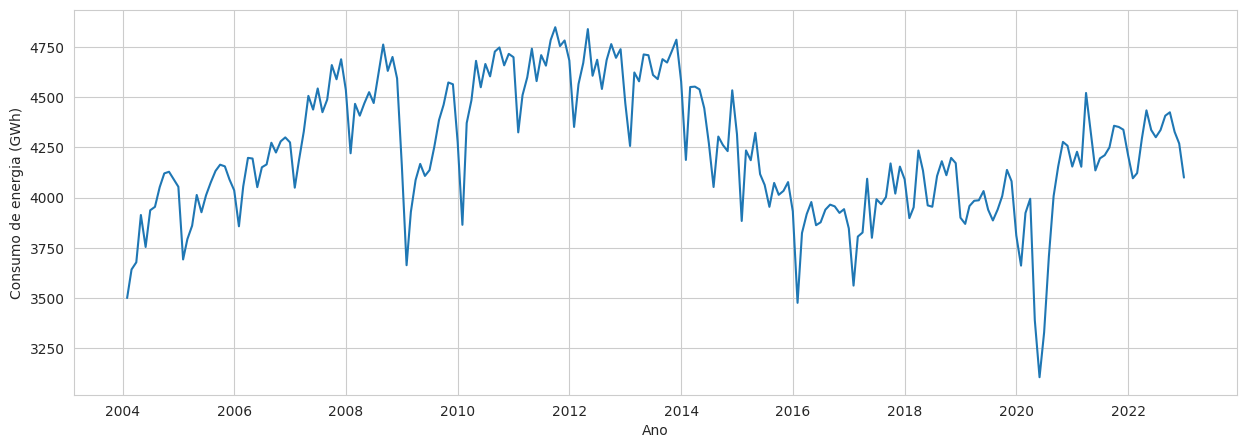

In [6]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (15,5))
sns.lineplot(ts, linewidth = 1.5)
ax.set_ylabel('Consumo de energia (GWh)')
ax.set_xlabel('Ano')
plt.grid(visible=True, axis='both')
plt.show()

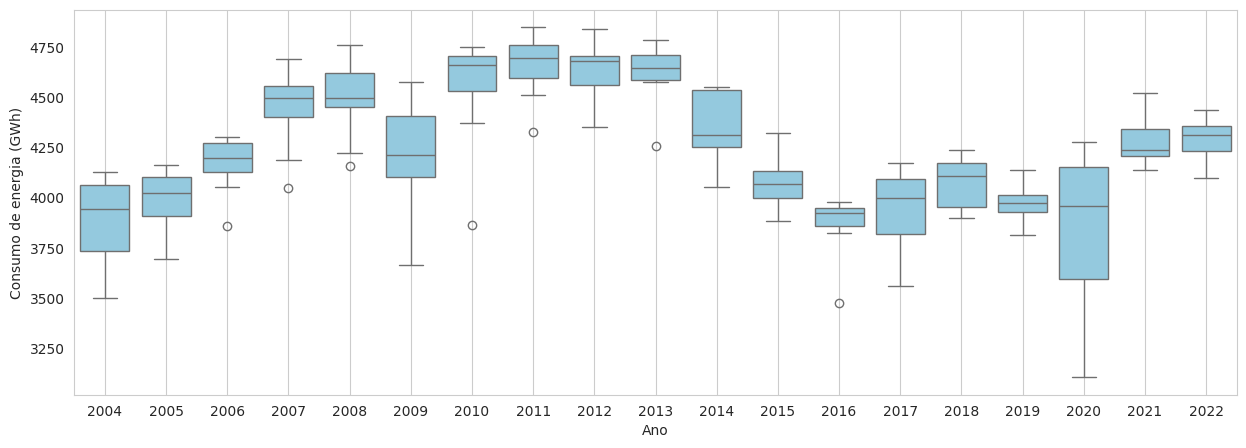

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x = ts.index.year,
                color = 'skyblue',
                y = ts.values,
                ax = ax)
ax.set_xlabel('Ano')
ax.set_ylabel('Consumo de energia (GWh)')
plt.grid()
plt.show()

/tmp/ipykernel_48081/2394867806.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez',])


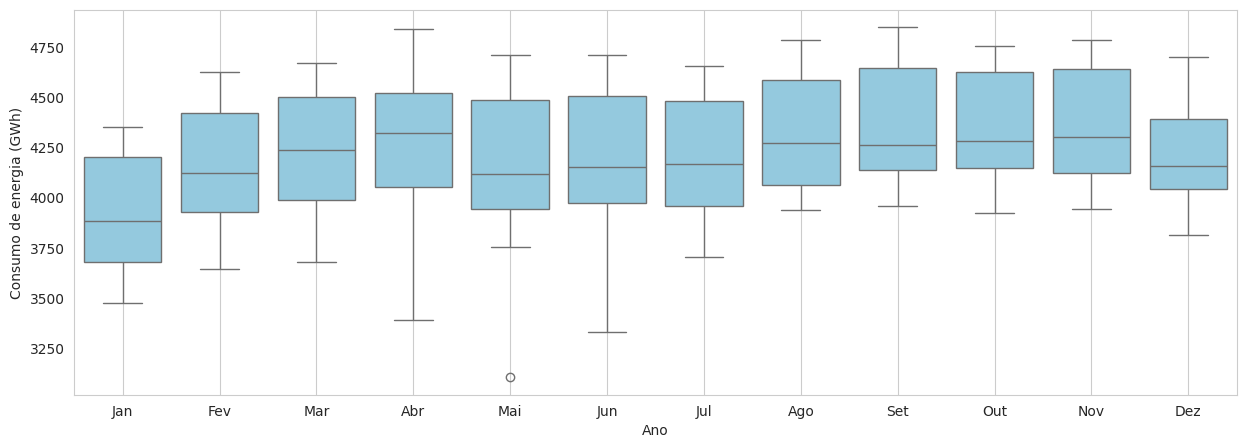

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x = ts.index.month,
                y = ts.values,
                color = 'skyblue',
                ax = ax)
ax.set_xticklabels(['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez',])
ax.set_xlabel('Ano')
ax.set_ylabel('Consumo de energia (GWh)')
plt.grid()
plt.show()

In [9]:
treino_ate_2021 = ts.loc[:'2021']
teste_2022 = ts.loc['2022']

treino_ate_2020 = ts.loc[:'2020']
teste_2021 = ts.loc['2021']

treino_ate_2019 = ts.loc[:'2019']
teste_2020 = ts.loc['2020']

treino_ate_2018 = ts.loc[:'2018']
teste_2019 = ts.loc['2019']


In [19]:
def erros(real, previsto, arredondamento = 5):
    erros_calculados = {'rmse':np.sqrt(mean_squared_error(real,previsto)).round(arredondamento) ,
                        'mape': mean_absolute_percentage_error(real,previsto).round(arredondamento)}
    return erros_calculados

# Ajuste do modelo ARIMA

## Teste 2022

In [13]:
ajuste_sarima_2022 = ARIMA(treino_ate_2021, order=(0,1,0), seasonal_order=(1,1,1,12))
ajuste_sarima_2022 = ajuste_sarima_2022.fit()
ajuste_sarima_2022.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  216
Model:             ARIMA(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1270.913
Date:                            Mon, 05 Feb 2024   AIC                           2547.827
Time:                                    14:08:15   BIC                           2557.766
Sample:                                01-31-2004   HQIC                          2551.848
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0562      0.125      0.448      0.654      -0.189       0.302
ma.S.L12      -0.7049      0.105     -6.729      0.000      -0.910      -0.500
sigma2      1.551e+04   1086.982     14.271      0.000    1.34e+04    1.76e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.10   Jarque-Bera (JB):               102.78
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
previsao_sarima_2022 = ajuste_sarima_2022.forecast(12)
erros_previsao_sarima_2022 = erros(previsao_sarima_2022, teste_2022)
erros_previsao_sarima_2022

{'rmse': 145.72146, 'mape': 0.03033}

## Teste 2021

In [17]:
ajuste_sarima_2021 = ARIMA(treino_ate_2020, order=(0,1,0), seasonal_order=(1,1,1,12))
ajuste_sarima_2021 = ajuste_sarima_2021.fit()
ajuste_sarima_2021.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             ARIMA(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1192.168
Date:                            Mon, 05 Feb 2024   AIC                           2390.335
Time:                                    14:11:56   BIC                           2400.092
Sample:                                01-31-2004   HQIC                          2394.287
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1959      0.120      1.632      0.103      -0.039       0.431
ma.S.L12      -0.8645      0.104     -8.318      0.000      -1.068      -0.661
sigma2       1.45e+04    887.084     16.347      0.000    1.28e+04    1.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):               182.87
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
previsao_sarima_2021 = ajuste_sarima_2021.forecast(12)
erros_previsao_sarima_2021 = erros(previsao_sarima_2021, teste_2021)
erros_previsao_sarima_2021

{'rmse': 173.0497, 'mape': 0.03201}

## Teste 2020

In [22]:
ajuste_sarima_2020 = ARIMA(treino_ate_2019, order=(0,1,0), seasonal_order=(1,1,1,12))
ajuste_sarima_2020 = ajuste_sarima_2020.fit()
ajuste_sarima_2020.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  192
Model:             ARIMA(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1091.963
Date:                            Mon, 05 Feb 2024   AIC                           2189.927
Time:                                    14:13:15   BIC                           2199.489
Sample:                                01-31-2004   HQIC                          2193.804
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2152      0.095      2.261      0.024       0.029       0.402
ma.S.L12      -0.9949      1.877     -0.530      0.596      -4.674       2.684
sigma2      1.001e+04   1.84e+04      0.544      0.586    -2.6e+04    4.61e+04
===================================================================================
Ljung-Box (L1) (Q):                  12.60   Jarque-Bera (JB):                 1.49
Prob(Q):                              0.00   Prob(JB):                         0.47
Heteroskedasticity (H):               1.31   Skew:                             0.13
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
previsao_sarima_2020 = ajuste_sarima_2020.forecast(12)
erros_previsao_sarima_2020 = erros(previsao_sarima_2020, teste_2020)
erros_previsao_sarima_2020

{'rmse': 352.80385, 'mape': 0.07642}

## Teste 2019

In [24]:
ajuste_sarima_2019 = ARIMA(treino_ate_2018, order=(0,1,0), seasonal_order=(1,1,1,12))
ajuste_sarima_2019 = ajuste_sarima_2019.fit()
ajuste_sarima_2019.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  180
Model:             ARIMA(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1016.292
Date:                            Mon, 05 Feb 2024   AIC                           2038.583
Time:                                    14:14:48   BIC                           2047.937
Sample:                                01-31-2004   HQIC                          2042.380
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1667      0.101      1.654      0.098      -0.031       0.364
ma.S.L12      -0.9918      1.171     -0.847      0.397      -3.287       1.303
sigma2      9608.1238   1.09e+04      0.881      0.378   -1.18e+04     3.1e+04
===================================================================================
Ljung-Box (L1) (Q):                  10.21   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.00   Prob(JB):                         0.46
Heteroskedasticity (H):               1.37   Skew:                             0.01
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
previsao_sarima_2019 = ajuste_sarima_2019.forecast(12)
erros_previsao_sarima_2019 = erros(previsao_sarima_2019, teste_2019)
erros_previsao_sarima_2019

{'rmse': 115.08575, 'mape': 0.02257}

### Plot do grafico comparando a série original com os periodos previstos

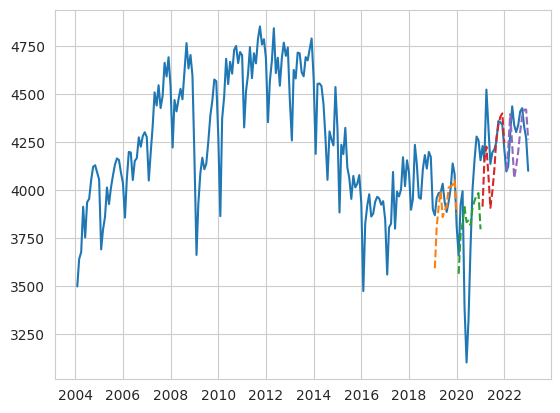

In [27]:
plt.plot(ts)
plt.plot(previsao_sarima_2019, '--')
plt.plot(previsao_sarima_2020,'--')
plt.plot(previsao_sarima_2021,'--')
plt.plot(previsao_sarima_2022,'--')

# Teste RNN

In [35]:
scaler = MinMaxScaler(feature_range=(0,1))
normalized_ts = scaler.fit_transform(np.array(ts).reshape(-1,1))



In [43]:
def treino_e_ajuste(dados, days_time_step,tamanho_treino, tamanho_teste):
    X_train, y_train = [], []
    for i in range(days_time_step, tamanho_treino):
        X_train.append(dados[i-days_time_step:i])
        y_train.append(dados[i])
    
#teste
    X_test = []
    for i in range(days_time_step, days_time_step + tamanho_teste):
        X_test.append(dados[i-days_time_step:i])
    return np.array(X_train), np.array(y_train), np.array(X_test)

In [111]:
X_treino_rnn_2022, y_treino_rnn_2022, X_teste_2022 = treino_e_ajuste(normalized_ts, 12, len(normalized_ts[:-12]), len(normalized_ts[-12:]))
X_treino_rnn_2021, y_treino_rnn_2021, X_teste_2021 = treino_e_ajuste(normalized_ts, 12, len(normalized_ts[:-24]), len(normalized_ts[-24:-12]))
X_treino_rnn_2020, y_treino_rnn_2020, X_teste_2020 = treino_e_ajuste(normalized_ts, 12, len(normalized_ts[:-36]), len(normalized_ts[-36:-24]))
X_treino_rnn_2019, y_treino_rnn_2019, X_teste_2019 = treino_e_ajuste(normalized_ts, 12, len(normalized_ts[:-48]), len(normalized_ts[-48:-36]))

## Teste 2022 RNN

In [132]:
modelo_rnn_2022 = Sequential()
modelo_rnn_2022.add(SimpleRNN(10,input_shape=(12,1)))
modelo_rnn_2022.add(Dense(1))
modelo_rnn_2022.compile(loss='mse')
modelo_rnn_2022.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 10)                120       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [133]:
modelo_ajustado = modelo_rnn_2022.fit(X_treino_rnn_2022, y_treino_rnn_2022, epochs=50)

Epoch 1/50


7/7 [==============================] - 1s 7ms/step - loss: 0.2524
Epoch 2/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0531
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0331
Epoch 4/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 5/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0256
Epoch 6/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0230
Epoch 7/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 8/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0174
Epoch 9/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0154
Epoch 10/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0137
Epoch 11/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 12/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 13/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 

In [134]:
previsao_rnn_2022 = modelo_rnn_2022.predict(X_teste_2022)
previsao_rnn_2022 = scaler.inverse_transform(previsao_rnn_2022)
previsao_rnn_2022 = previsao_rnn_2022.reshape(12)
previsao_rnn_2022

1/1 [==============================] - 0s 238ms/step


array([4018.483 , 3813.341 , 3935.1628, 3931.352 , 4056.3318, 3949.1523,
       4057.9932, 4176.229 , 4227.644 , 4311.335 , 4295.9683, 4218.576 ],
      dtype=float32)

In [135]:
erros_rnn_2022 = erros(previsao_rnn_2022, teste_2022.values)
erros_rnn_2022

{'rmse': 269.76951, 'mape': 0.0573}

## Teste 2021

In [136]:
modelo_rnn_2021 = Sequential()
modelo_rnn_2021.add(SimpleRNN(10,input_shape=(12,1)))
modelo_rnn_2021.add(Dense(1))
modelo_rnn_2021.compile(loss='mse')
modelo_rnn_2021.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 10)                120       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [137]:
modelo_ajustado_2021 = modelo_rnn_2021.fit(X_treino_rnn_2021, y_treino_rnn_2021, epochs=50)

Epoch 1/50


6/6 [==============================] - 1s 6ms/step - loss: 0.0249
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0173
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0168
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0162
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0153
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0161
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0143
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 11/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 12/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0140
Epoch 13/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0135
Epoch 

In [138]:
previsao_rnn_2021 = modelo_rnn_2021.predict(X_teste_2021)
previsao_rnn_2021 = scaler.inverse_transform(previsao_rnn_2021)
previsao_rnn_2021 = previsao_rnn_2021.reshape(12)
previsao_rnn_2021

1/1 [==============================] - 0s 218ms/step


array([4036.984 , 3844.105 , 3837.5671, 3906.2495, 3928.5967, 3914.0923,
       3932.8438, 4034.2275, 4135.535 , 4227.462 , 4175.638 , 4097.5547],
      dtype=float32)

In [139]:
erros_rnn_2021 = erros(previsao_rnn_2021,teste_2021.values)
erros_rnn_2021

{'rmse': 307.15855, 'mape': 0.06786}

## Teste 2020

In [140]:
modelo_rnn_2020 = Sequential()
modelo_rnn_2020.add(SimpleRNN(10,input_shape=(12,1)))
modelo_rnn_2020.add(Dense(1))
modelo_rnn_2020.compile(loss='mse')
modelo_rnn_2020.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 10)                120       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [141]:
modelo_ajustado_2020 = modelo_rnn_2020.fit(X_treino_rnn_2020, y_treino_rnn_2020, epochs=50)

Epoch 1/50
6/6 [==============================] - 1s 6ms/step - loss: 0.0298
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0187
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0170
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0144
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 7/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 8/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 11/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 12/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 13/50
6/6 [==============================] - 0s 8ms/step - loss: 0.

In [142]:
previsao_rnn_2020 = modelo_rnn_2020.predict(X_teste_2020)
previsao_rnn_2020 = scaler.inverse_transform(previsao_rnn_2020)
previsao_rnn_2020 = previsao_rnn_2020.reshape(12)
previsao_rnn_2020

1/1 [==============================] - 0s 254ms/step


array([4046.0342, 3934.0261, 3941.012 , 3970.5498, 3861.9995, 3858.6443,
       3918.986 , 4098.422 , 4217.9033, 4306.6084, 4383.217 , 4306.0146],
      dtype=float32)

In [143]:
erros_rnn_2020 = erros(previsao_rnn_2020,teste_2020.values)
erros_rnn_2020

{'rmse': 346.68432, 'mape': 0.06276}

## Teste 2019

In [144]:
modelo_rnn_2019 = Sequential()
modelo_rnn_2019.add(SimpleRNN(10,input_shape=(12,1)))
modelo_rnn_2019.add(Dense(1))
modelo_rnn_2019.compile(loss='mse')
modelo_rnn_2019.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (None, 10)                120       
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [145]:
modelo_ajustado_2019 = modelo_rnn_2019.fit(X_treino_rnn_2019, y_treino_rnn_2019, epochs=50)

Epoch 1/50
6/6 [==============================] - 1s 7ms/step - loss: 0.2888
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.1249
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0609
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0366
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0310
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0288
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0274
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0256
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0241
Epoch 10/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0223
Epoch 11/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0214
Epoch 12/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 13/50
6/6 [==============================] - 0s 7ms/step - loss: 

In [146]:
previsao_rnn_2019 = modelo_rnn_2019.predict(X_teste_2019)
previsao_rnn_2019 = scaler.inverse_transform(previsao_rnn_2019)
previsao_rnn_2019 = previsao_rnn_2019.reshape(12)
previsao_rnn_2019

1/1 [==============================] - 0s 247ms/step


array([3847.3972, 3676.571 , 3839.8633, 3863.7148, 3848.087 , 3888.7583,
       3976.4705, 4147.0703, 4086.432 , 4134.3022, 4094.0383, 4095.7764],
      dtype=float32)

In [147]:
erros_rnn_2019 = erros(previsao_rnn_2019,teste_2019.values)
erros_rnn_2019

{'rmse': 155.60795, 'mape': 0.03149}